In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [29]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/WISDM.csv", header=None, names=names, skiprows=1)

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')
    # ... and then this column must be transformed to float explicitly
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

(1098203, 6)


In [4]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098203 entries, 0 to 1098202
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x_axis     1098203 non-null  float64
 4   y_axis     1098203 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [6]:
df = df[~df['activity'].str.contains('Jogging|Sitting|Upstairs|Downstairs')]

In [7]:
print(df['activity'].value_counts())

Walking     424397
Standing     48395
Name: activity, dtype: int64


In [8]:
mapping = {'Walking': 0, 'Standing': 1}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
597,33,Walking,49394992294000,0.844462,8.008764,2.792171,0
598,33,Walking,49395102310000,1.116869,8.621680,3.786457,0
599,33,Walking,49395202316000,-0.503953,16.657684,1.307553,0
600,33,Walking,49395302292000,4.794363,10.760075,-1.184970,0
601,33,Walking,49395412338000,-0.040861,9.234595,-0.694638,0
...,...,...,...,...,...,...,...
1095664,19,Standing,131477821443000,-4.990000,8.390000,-0.380000,1
1095665,19,Standing,131477861513000,-5.130000,8.240000,-0.420000,1
1095666,19,Standing,131477941499000,-4.560000,8.500000,-0.890000,1
1095667,19,Standing,131477981508000,-4.480000,8.540000,-1.080000,1


In [9]:
df.shape

(472792, 7)

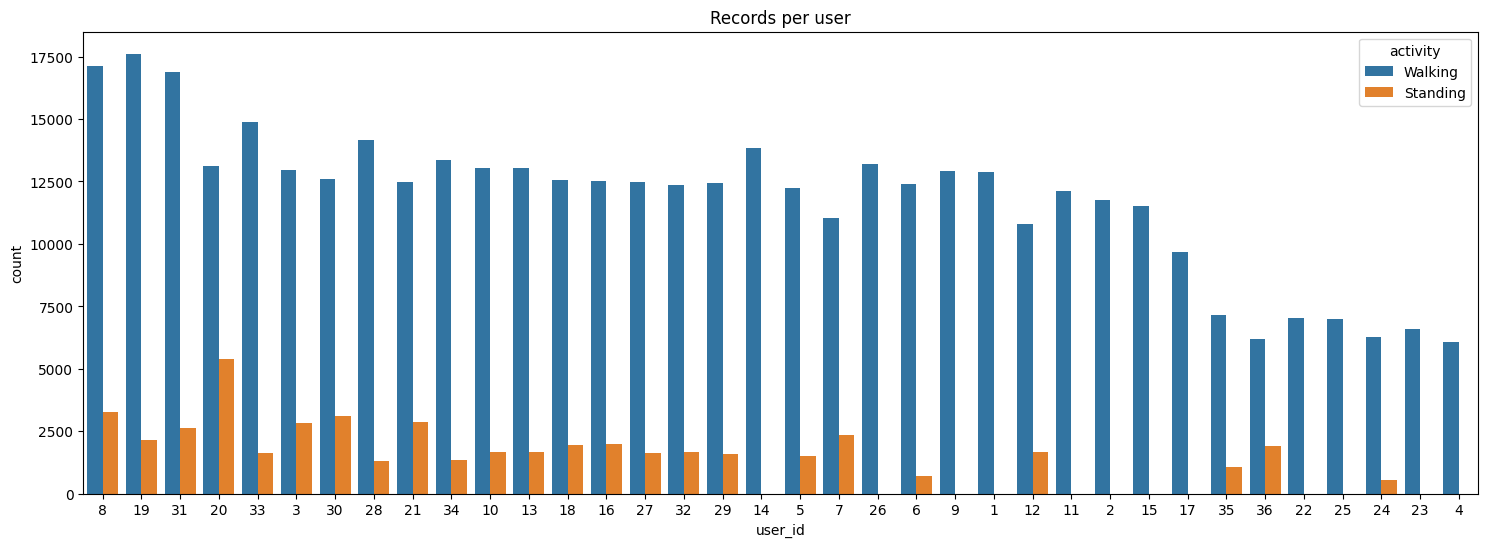

In [10]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = df,
              order = df.user_id.value_counts().index)
plt.title("Records per user");

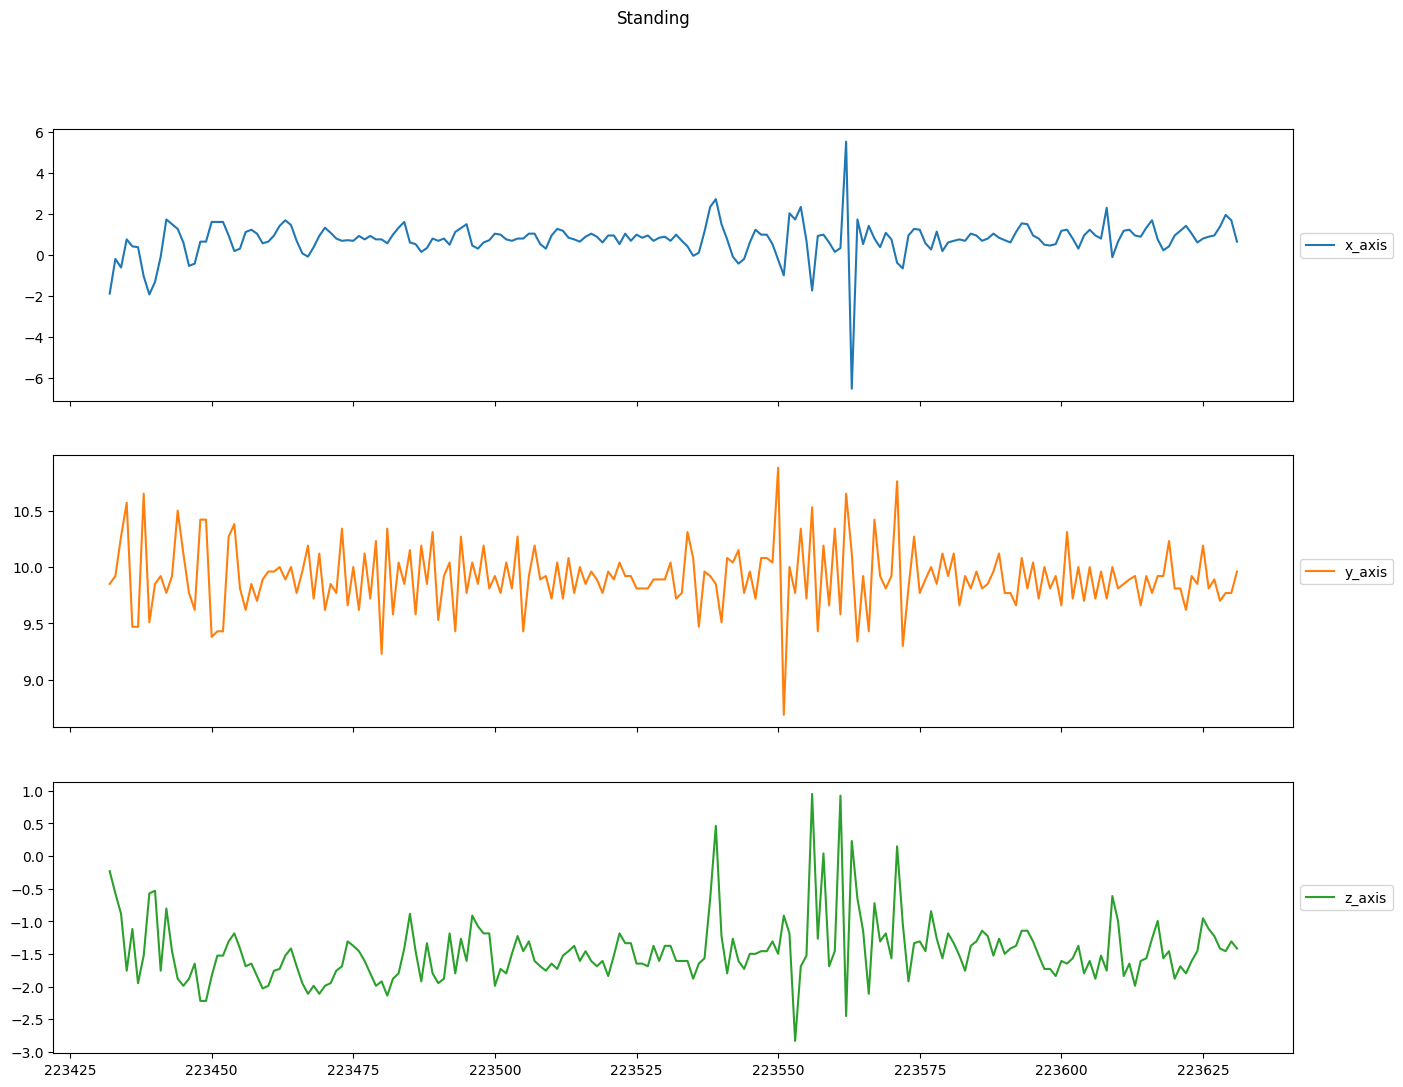

In [11]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7561, 200, 3) (7561, 1)
(2363, 200, 3) (2363, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(7561, 200, 3) (7561, 2) (2363, 200, 3) (2363, 2)


In [14]:
#Epoch 20

BATCH_SIZE = 128

verbose,epochs,batch_size=1,20, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 2)

<h1>Epoch 10 (Data Balancing X)</h1>

In [15]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(n_timesteps,n_features)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200, 100)          400       
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40402 (157.82 KB)
Trainable params: 40402 (157.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
60/60 [==============================] - 5s 64ms/step - loss: 1.0666 - accuracy: 0.8584 - val_loss: 0.2233 - val_accuracy: 0.9339
Epoch 2/10
60/60 [==============================] - 4s 64ms/step - loss: 0.2307 - accuracy: 0.9296 - val_loss: 0.2306 - val_accuracy: 0.8985
Epoch 3/10
60/60 [==============================] - 5s 86ms/step - loss: 0.2040 - accuracy: 0.9368 - val_loss: 0.1634 - val_accuracy: 0.9762
Epoch 4/10
60/60 [==============================] - 4s 64ms/step - loss: 0.1605 - accuracy: 0.9631 - val_loss: 0.1353 - val_accuracy: 0.9588
Epoch 5/10
60/60 [==============================] - 3s 58ms/step - loss: 0.1223 - accuracy: 0.9757 - val_loss: 0.1259 - val_accuracy: 0.9820
Epoch 6/10
60/60 [==============================] - 5s 79ms/step - loss: 0.1134 - accuracy: 0.9689 - val_loss: 0.0860 - val_accuracy: 0.9709
Epoch 7/10
60/60 [==============================] - 4s 65ms/step - loss: 0.0792 - accuracy: 0.9832 - val_loss: 0.0755 - val_accuracy: 0.9730
Epoch 8/10
60

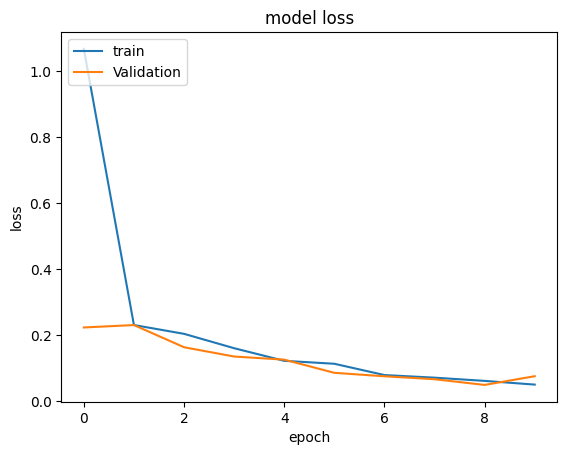

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

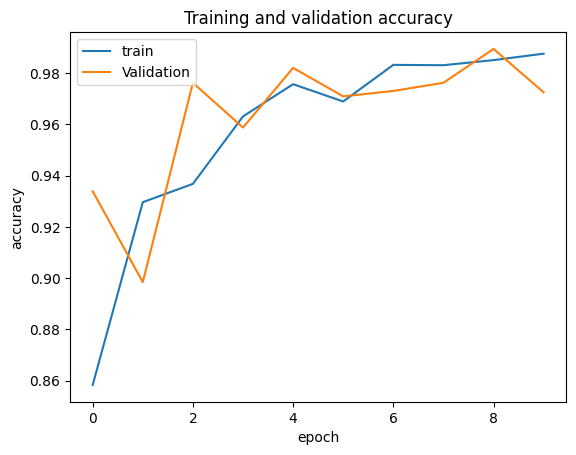

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

74/74 [==============================] - 1s 8ms/step
f1_score =  0.9724980668591449
0.9741853575962759
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2122
           1       1.00      0.75      0.86       241

    accuracy                           0.97      2363
   macro avg       0.99      0.87      0.92      2363
weighted avg       0.97      0.97      0.97      2363



<Axes: >

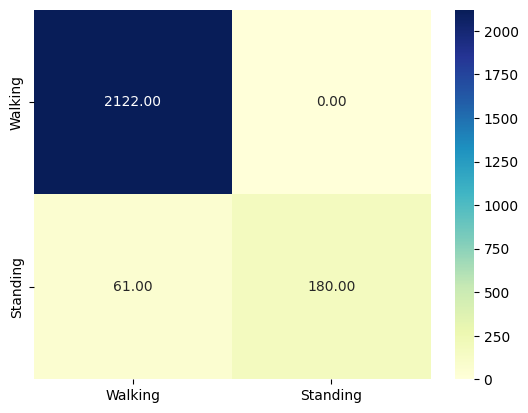

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Epoch 20 (Data Balancing X)</h1>

In [20]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(n_timesteps,n_features)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 200, 100)          400       
                                                                 
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40402 (157.82 KB)
Trainable params: 40402 (157.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/20
60/60 [==============================] - 4s 56ms/step - loss: 1.1843 - accuracy: 0.8546 - val_loss: 0.2644 - val_accuracy: 0.8979
Epoch 2/20
60/60 [==============================] - 2s 40ms/step - loss: 0.2420 - accuracy: 0.9251 - val_loss: 0.1992 - val_accuracy: 0.9381
Epoch 3/20
60/60 [==============================] - 2s 41ms/step - loss: 0.2167 - accuracy: 0.9357 - val_loss: 0.3107 - val_accuracy: 0.8556
Epoch 4/20
60/60 [==============================] - 2s 34ms/step - loss: 0.1825 - accuracy: 0.9554 - val_loss: 0.1405 - val_accuracy: 0.9773
Epoch 5/20
60/60 [==============================] - 2s 28ms/step - loss: 0.1405 - accuracy: 0.9689 - val_loss: 0.1050 - val_accuracy: 0.9783
Epoch 6/20
60/60 [==============================] - 2s 28ms/step - loss: 0.1271 - accuracy: 0.9667 - val_loss: 0.0872 - val_accuracy: 0.9825
Epoch 7/20
60/60 [==============================] - 2s 29ms/step - loss: 0.0986 - accuracy: 0.9766 - val_loss: 0.0779 - val_accuracy: 0.9699
Epoch 8/20
60

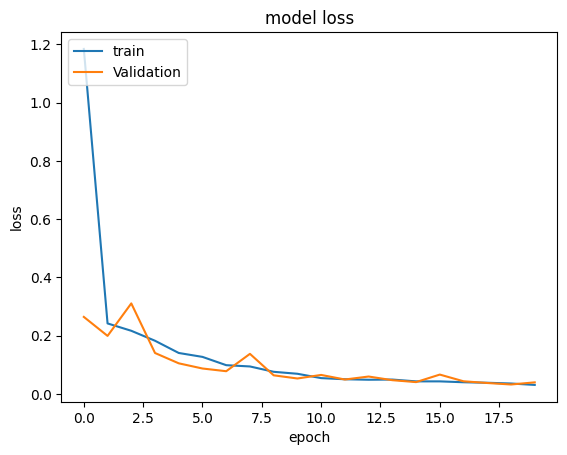

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

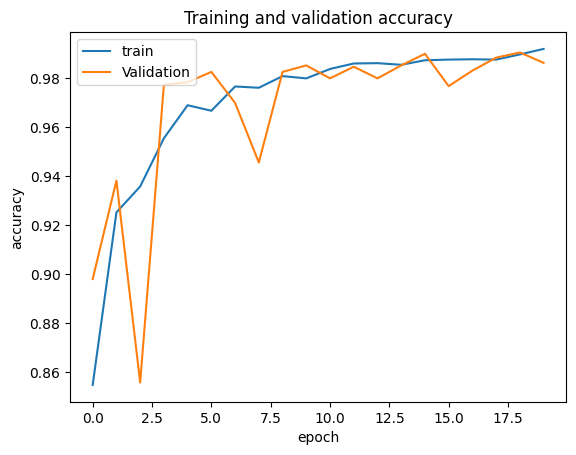

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

74/74 [==============================] - 0s 5ms/step
f1_score =  0.9922660981554654
0.992382564536606
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2122
           1       1.00      0.93      0.96       241

    accuracy                           0.99      2363
   macro avg       0.99      0.96      0.98      2363
weighted avg       0.99      0.99      0.99      2363



<Axes: >

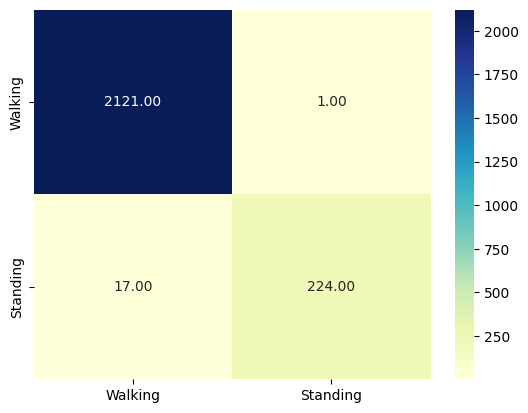

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Data Balacing</h1>

In [30]:
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersample.fit_resample(df.drop('activity', axis=1), df['activity'])

In [31]:
df = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('activity', axis=1).columns),
                         pd.DataFrame({'activity': y_resampled})], axis=1)

In [32]:
print(df['activity'].value_counts())

Standing    48395
Walking     48395
Name: activity, dtype: int64


In [33]:
df.head()

,user_id,timestamp,x_axis,y_axis,z_axis,ActivityEncoded,activity
0,27,12535892255000,-1.88,9.85,-0.231546,1,Standing
1,27,12535942273000,-0.19,9.92,-0.572055,1,Standing
2,27,12535992231000,-0.61,10.27,-0.885323,1,Standing
3,27,12536042310000,0.76,10.57,-1.757025,1,Standing
4,27,12536092206000,0.42,9.47,-1.116869,1,Standing


In [34]:
df.shape

(96790, 7)

Text(0.5, 1.0, 'Records per user')

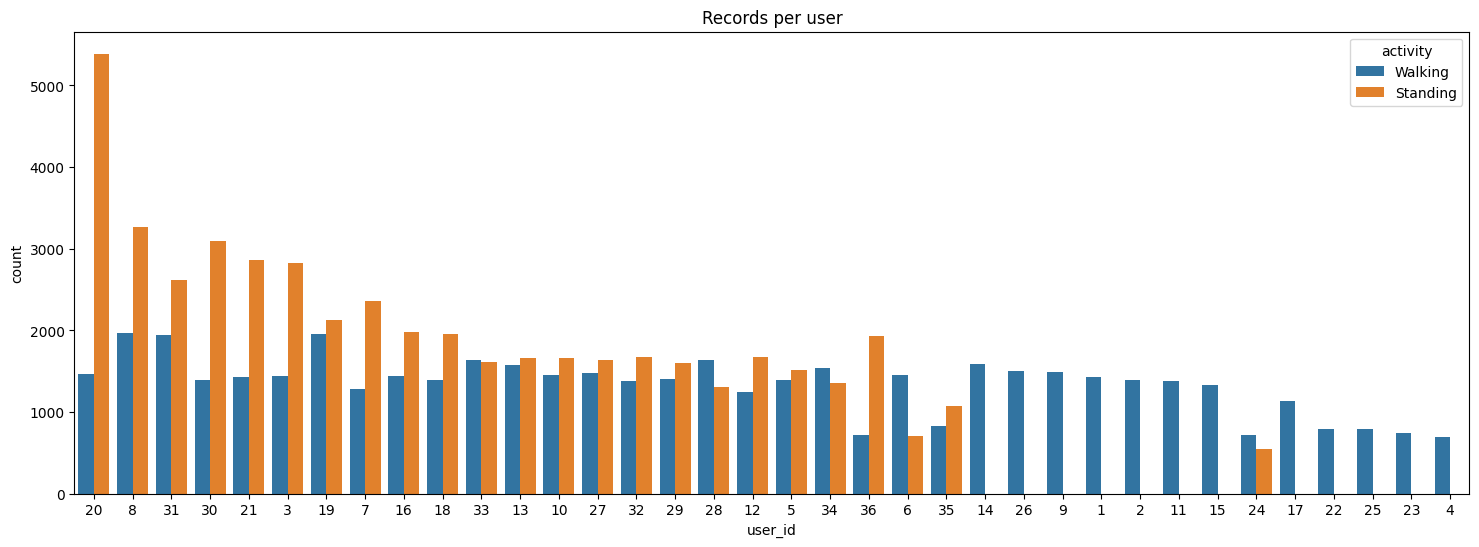

In [35]:
plt.figure(figsize=(18, 6))
sns.countplot(x = "user_id", hue="activity", data = df,
              order = df.user_id.value_counts().index)
plt.title("Records per user")

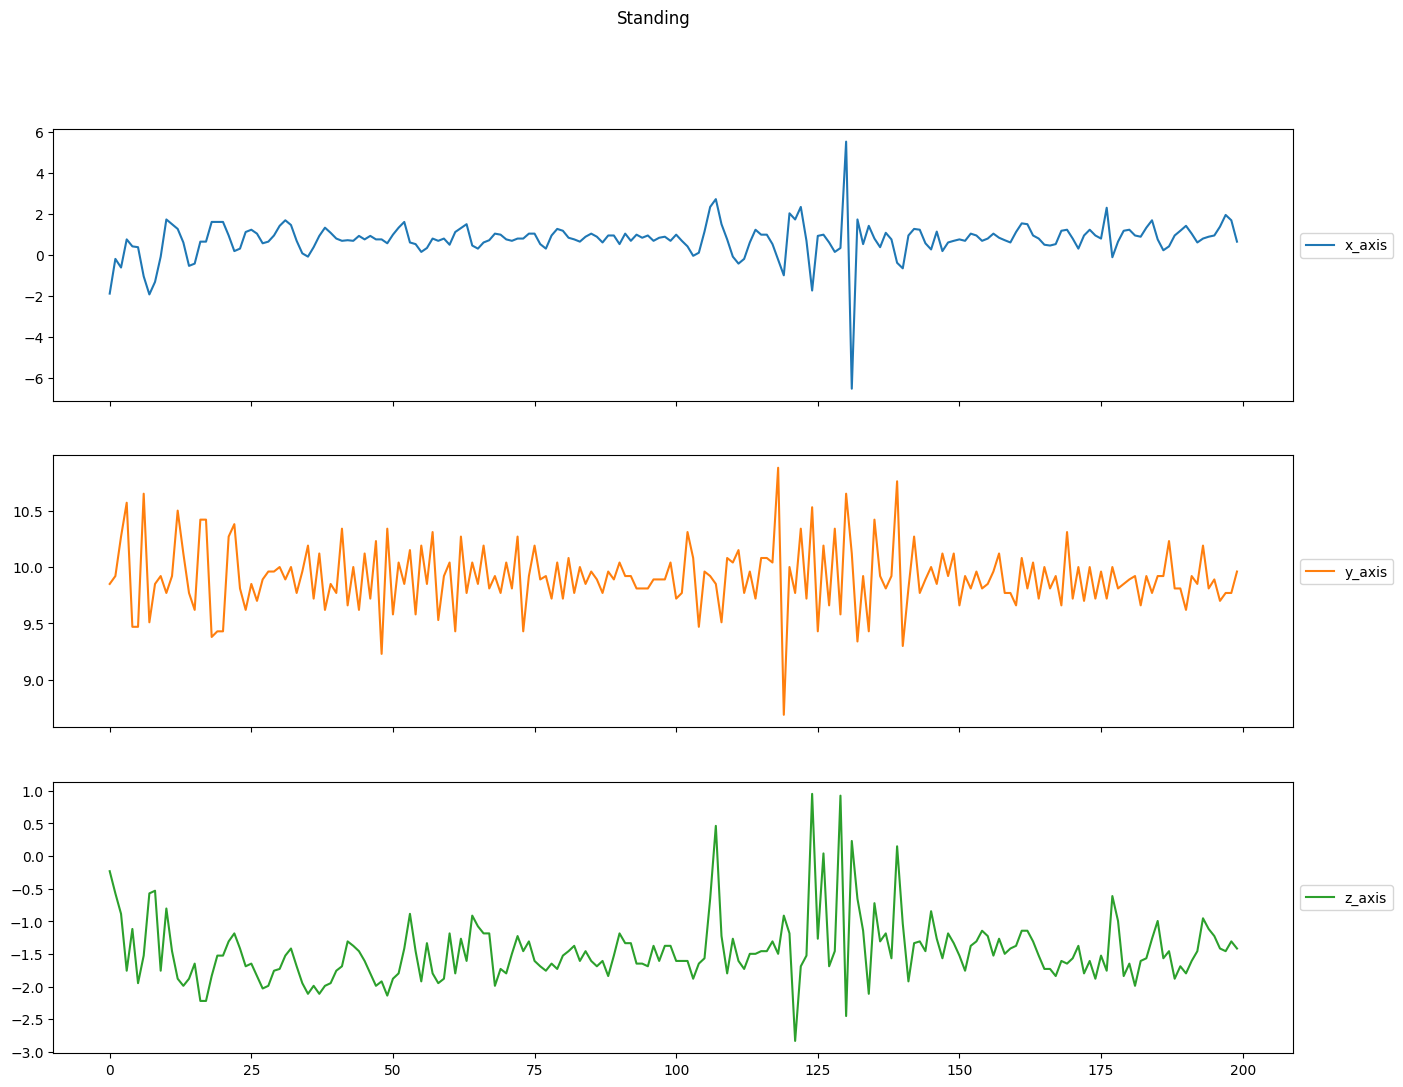

In [36]:
def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Standing", df)

In [37]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1545, 200, 3) (1545, 1)
(483, 200, 3) (483, 1)


In [38]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(1545, 200, 3) (1545, 2) (483, 200, 3) (483, 2)


In [39]:
#Epoch 10

BATCH_SIZE = 128

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 2)

<h1>Epoch 10 (Data Balancing O - UnderSampling)</h1>

In [40]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(n_timesteps,n_features)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200, 100)          400       
                                                                 
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40402 (157.82 KB)
Trainable params: 40402 (157.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/10
13/13 [==============================] - 2s 76ms/step - loss: 3.4774 - accuracy: 0.5282 - val_loss: 1.6286 - val_accuracy: 0.4884
Epoch 2/10
13/13 [==============================] - 1s 47ms/step - loss: 0.7997 - accuracy: 0.7126 - val_loss: 0.5605 - val_accuracy: 0.8941
Epoch 3/10
13/13 [==============================] - 1s 52ms/step - loss: 0.4661 - accuracy: 0.9197 - val_loss: 0.3596 - val_accuracy: 0.9509
Epoch 4/10
13/13 [==============================] - 1s 72ms/step - loss: 0.3366 - accuracy: 0.9540 - val_loss: 0.2907 - val_accuracy: 0.9302
Epoch 5/10
13/13 [==============================] - 1s 63ms/step - loss: 0.3005 - accuracy: 0.9482 - val_loss: 0.2976 - val_accuracy: 0.9251
Epoch 6/10
13/13 [==============================] - 1s 59ms/step - loss: 0.2928 - accuracy: 0.9450 - val_loss: 0.2737 - val_accuracy: 0.9483
Epoch 7/10
13/13 [==============================] - 1s 71ms/step - loss: 0.2917 - accuracy: 0.9540 - val_loss: 0.2698 - val_accuracy: 0.9483
Epoch 8/10
13

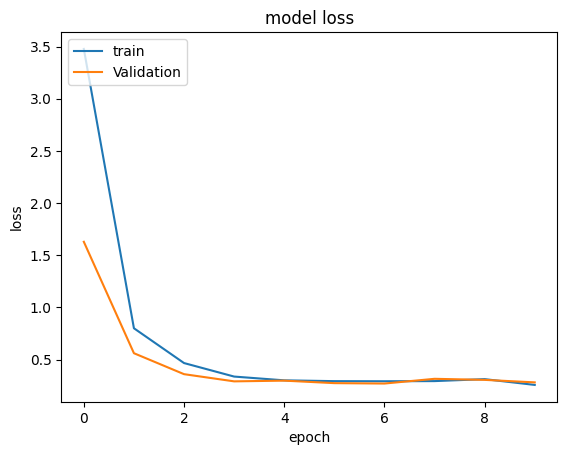

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

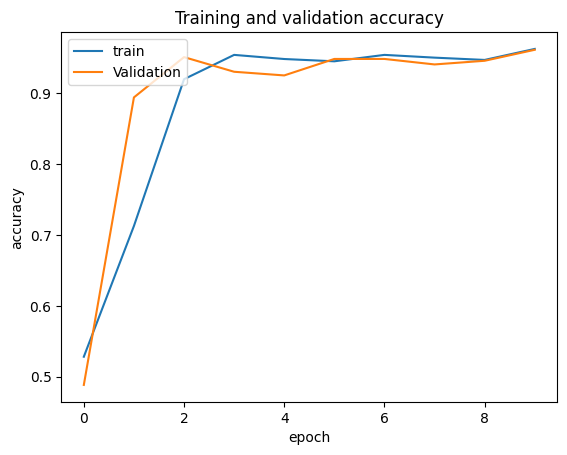

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

16/16 [==============================] - 0s 9ms/step
f1_score =  0.9357814672685901
0.9358178053830227
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       241
           1       0.92      0.96      0.94       242

    accuracy                           0.94       483
   macro avg       0.94      0.94      0.94       483
weighted avg       0.94      0.94      0.94       483



<Axes: >

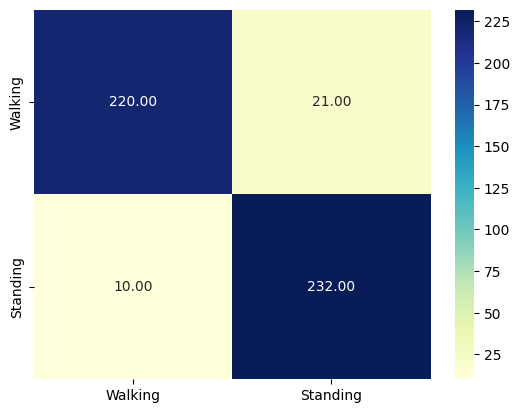

In [44]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>Epoch 20 (Data Balancing O - UnderSampling)</h1>

In [45]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='sigmoid', input_shape=(n_timesteps,n_features)))
model.add(Flatten())
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200, 100)          400       
                                                                 
 flatten_3 (Flatten)         (None, 20000)             0         
                                                                 
 dense_7 (Dense)             (None, 2)                 40002     
                                                                 
Total params: 40402 (157.82 KB)
Trainable params: 40402 (157.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# validation_split = 0.1
batch_size = 128

train_epochs = 20
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 69ms/step - loss: 1.4930 - accuracy: 0.6265 - val_loss: 0.8675 - val_accuracy: 0.4806
Epoch 2/20
13/13 [==============================] - 1s 52ms/step - loss: 0.6014 - accuracy: 0.7819 - val_loss: 0.3630 - val_accuracy: 0.9457
Epoch 3/20
13/13 [==============================] - 1s 68ms/step - loss: 0.3546 - accuracy: 0.9392 - val_loss: 0.3136 - val_accuracy: 0.9302
Epoch 4/20
13/13 [==============================] - 1s 68ms/step - loss: 0.2998 - accuracy: 0.9424 - val_loss: 0.2998 - val_accuracy: 0.9251
Epoch 5/20
13/13 [==============================] - 1s 60ms/step - loss: 0.2939 - accuracy: 0.9424 - val_loss: 0.3367 - val_accuracy: 0.9251
Epoch 6/20
13/13 [==============================] - 1s 58ms/step - loss: 0.2903 - accuracy: 0.9521 - val_loss: 0.2905 - val_accuracy: 0.9328
Epoch 7/20
13/13 [==============================] - 1s 54ms/step - loss: 0.3022 - accuracy: 0.9398 - val_loss: 0.2786 - val_accuracy: 0.9328
Epoch 8/20
13

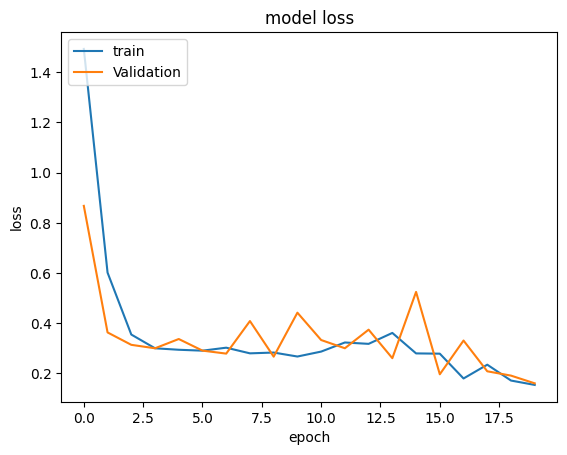

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

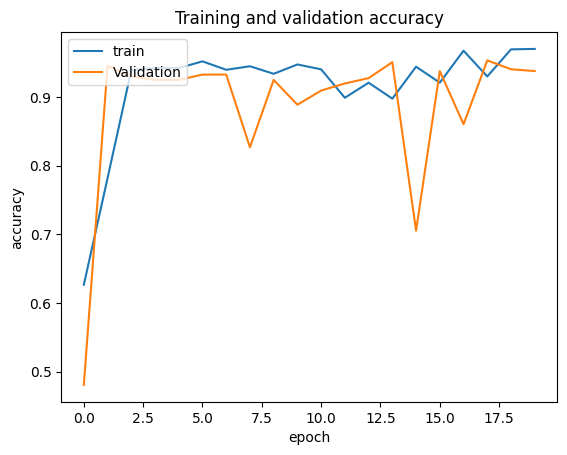

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

16/16 [==============================] - 0s 7ms/step
f1_score =  0.9522774527220307
0.9523809523809523
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       241
           1       1.00      0.90      0.95       242

    accuracy                           0.95       483
   macro avg       0.96      0.95      0.95       483
weighted avg       0.96      0.95      0.95       483



<Axes: >

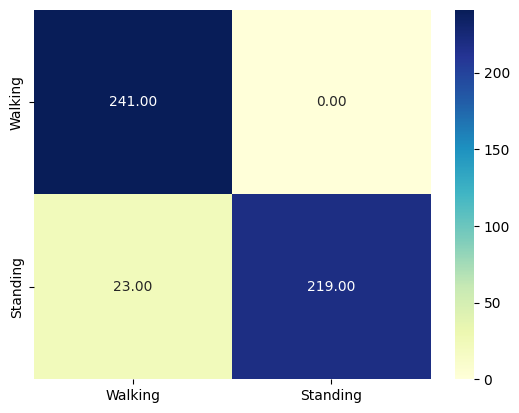

In [49]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking','Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')